# Data science assessment - Fraud data

## objective
> to buld a machine learning model that predicts the probability that the first transaction of a new user is fraudulent

## details
- 'Electronica' : e-commerce site that sells wholesale electronics
- want to know a given transaction is fraudulent or not
- data of user's first transaction
- costs
    - fail to detect fraud : Electronica loses money equivalent to the price
    - false alert          : cost my client values 8$

# Load Libraries

In [100]:
# python built-in libraries
import os
from collections import Counter
from datetime import datetime, timedelta

# python third party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# setting
random_state = 79

## load data

In [101]:
directory = os.getcwd()
directory

'/Users/nm-n2204009/Desktop/notes/novelis'

In [234]:
fraud_data = pd.read_csv(directory + '/dataset/Candidate_tech_evaluation_candidate_copy_data science_fraud.csv', index_col=0)
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
149671,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
15611,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
73178,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
84546,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
35978,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


In [161]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 149671 to 46646
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         120000 non-null  int64  
 1   signup_time     120000 non-null  object 
 2   purchase_time   120000 non-null  object 
 3   purchase_value  120000 non-null  int64  
 4   device_id       120000 non-null  object 
 5   source          120000 non-null  object 
 6   browser         120000 non-null  object 
 7   sex             120000 non-null  object 
 8   age             120000 non-null  int64  
 9   ip_address      120000 non-null  float64
 10  class           120000 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 11.0+ MB


In [162]:
ip_info = pd.read_excel(directory + '/dataset/Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx')
ip_info.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216,16777471,Australia
1,16777472,16777727,China
2,16777728,16778239,China
3,16778240,16779263,Australia
4,16779264,16781311,China


In [163]:
ip_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   lower_bound_ip_address  138846 non-null  int64 
 1   upper_bound_ip_address  138846 non-null  int64 
 2   country                 138846 non-null  object
dtypes: int64(2), object(1)
memory usage: 3.2+ MB


# EDA

## class

In [12]:
## label imbalance check
Counter(fraud_data['class'])

Counter({0: 108735, 1: 11265})

(array([108735.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  11265.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

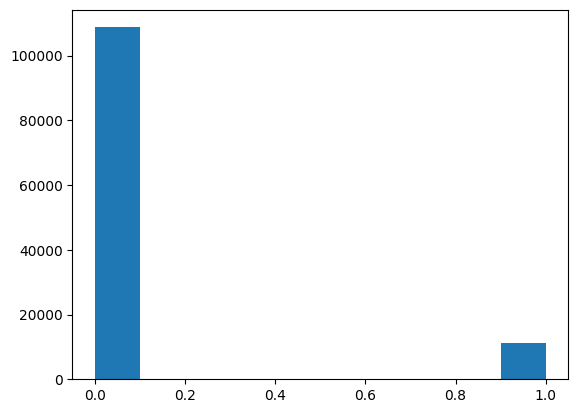

In [13]:
## highly imbalanced
plt.hist(fraud_data['class'])

## signup_time & purchase_time

- fraud users decrease at Jan
- looks like (signup_time - purchase_time) diff matters
- joined month&date + purchased month&date could be important for fraud detaction

In [235]:
fraud_data['signup_time'] = fraud_data['signup_time'].astype(str)
fraud_data['signup_time_date'] = fraud_data['signup_time'].map(lambda x : datetime.strptime(x.split(' ')[0], '%m/%d/%Y'))
fraud_data['signup_time_date']

149671   2015-07-15
15611    2015-01-24
73178    2015-03-11
84546    2015-01-07
35978    2015-02-08
            ...    
13862    2015-02-26
122655   2015-08-01
125965   2015-07-25
31108    2015-04-02
46646    2015-07-15
Name: signup_time_date, Length: 120000, dtype: datetime64[ns]

In [236]:
fraud_data['purchase_time']      = fraud_data['purchase_time'].astype(str)
fraud_data['purchase_time_date'] = fraud_data['purchase_time'].map(lambda x : datetime.strptime(x.split(' ')[0], '%m/%d/%Y'))
fraud_data['purchase_time_date']

149671   2015-09-10
15611    2015-04-13
73178    2015-04-05
84546    2015-01-09
35978    2015-04-09
            ...    
13862    2015-04-16
122655   2015-08-25
125965   2015-09-03
31108    2015-06-22
46646    2015-09-03
Name: purchase_time_date, Length: 120000, dtype: datetime64[ns]

In [237]:
fraud_data['time_to_purchase'] = fraud_data['purchase_time_date'] - fraud_data['signup_time_date']
fraud_data['time_to_purchase'] = fraud_data['time_to_purchase'].dt.days
fraud_data['time_to_purchase']

149671    57
15611     79
73178     25
84546      2
35978     60
          ..
13862     49
122655    24
125965    40
31108     81
46646     50
Name: time_to_purchase, Length: 120000, dtype: int64

In [126]:
tmp_df = pd.DataFrame(fraud_data.groupby(['time_to_purchase', 'class'])['user_id'].count()).reset_index()
tmp_df

,time_to_purchase,class,user_id
0,0,0,445
1,0,1,6048
2,1,0,889
3,1,1,34
4,2,0,863
...,...,...,...
237,118,1,51
238,119,0,916
239,119,1,48
240,120,0,451


- if the less time taken to purchase for the first time, the more likely to be fraud

<Axes: xlabel='time_to_purchase', ylabel='user_id'>

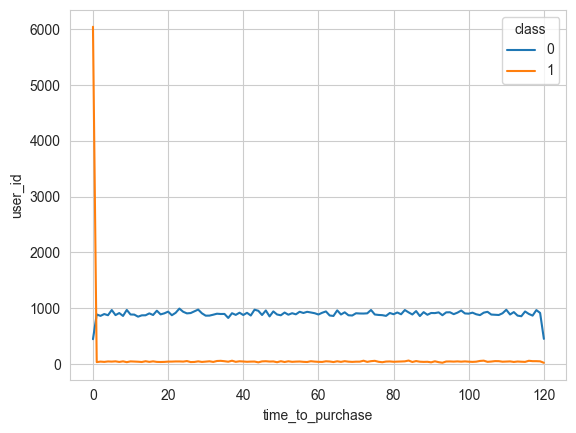

In [127]:
sns.lineplot(x="time_to_purchase", y="user_id",
             hue = 'class',
             data=tmp_df)

In [114]:
fraud_data.loc[(fraud_data['class'] == 1) & (fraud_data['time_to_purchase'] >= 10)]

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,signup_time_date,purchase_time_date,time_to_purchase,user_id_count,country
58,238906,1/7/2015 21:49,2/15/2015 17:29,61,OYUCSCPRHJDKG,Ads,Safari,F,38,4.019587e+09,1,2015-01-07,2015-02-15,39,2,
83,53598,8/3/2015 21:55,11/18/2015 23:41,36,ZRDWELSXIWOJS,SEO,FireFox,M,40,3.426213e+09,1,2015-08-03,2015-11-18,107,1,United States
148,68925,7/3/2015 22:36,7/31/2015 7:30,44,QMXTUXAPZSTDP,SEO,Chrome,F,38,3.917948e+09,1,2015-07-03,2015-07-31,28,1,
158,59440,4/13/2015 5:33,5/13/2015 9:34,18,PAFLMZPDNZUDL,SEO,Chrome,M,30,3.409258e+09,1,2015-04-13,2015-05-13,30,1,Australia
159,251425,6/19/2015 20:50,7/26/2015 13:41,25,ANQJBFXVGLNXK,Ads,IE,M,37,3.504390e+09,1,2015-06-19,2015-07-26,37,2,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119927,379096,2/8/2015 18:41,5/16/2015 5:46,38,LITTRXARHUAFP,Ads,IE,M,39,1.259363e+09,1,2015-02-08,2015-05-16,97,1,United States
119930,113437,5/23/2015 16:02,7/4/2015 22:15,14,DRYPJKBSZQPCH,Ads,Chrome,M,34,3.133319e+09,1,2015-05-23,2015-07-04,42,2,Brazil
119940,55107,1/20/2015 18:31,4/23/2015 3:37,43,XIFNFVKLWZCJK,SEO,FireFox,M,30,1.523859e+09,1,2015-01-20,2015-04-23,93,2,United Kingdom
119946,194429,2/21/2015 7:20,6/16/2015 21:22,65,GXUGXEHBAOEXA,SEO,Chrome,M,40,3.581044e+08,1,2015-02-21,2015-06-16,115,1,United States


## fraud / normal signup count 

In [17]:
tmp_df = pd.DataFrame(fraud_data.groupby(['signup_time_date', 'class'])['user_id'].count()).reset_index()
tmp_df

,signup_time_date,class,user_id
0,2015-01-01,0,475
1,2015-01-01,1,496
2,2015-01-02,0,499
3,2015-01-02,1,589
4,2015-01-03,0,462
...,...,...,...
455,2015-08-16,1,29
456,2015-08-17,0,486
457,2015-08-17,1,28
458,2015-08-18,0,97


<Axes: xlabel='signup_time_date', ylabel='user_id'>

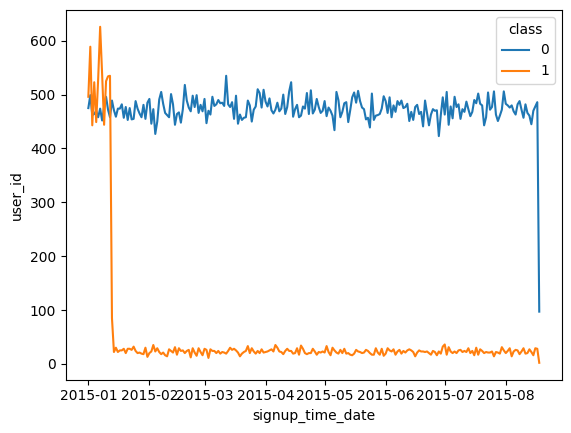

In [18]:
sns.lineplot(x="signup_time_date", y="user_id",
             hue = 'class',
             data=tmp_df)

## About purchase value

## fraud / normal purchase value sum / avg / max min diff

In [19]:
tmp_df = pd.DataFrame(fraud_data.groupby(['signup_time_date', 'class'])['purchase_value'].sum()).reset_index()
tmp_df

,signup_time_date,class,purchase_value
0,2015-01-01,0,17491
1,2015-01-01,1,16446
2,2015-01-02,0,18677
3,2015-01-02,1,22100
4,2015-01-03,0,17067
...,...,...,...
455,2015-08-16,1,903
456,2015-08-17,0,18068
457,2015-08-17,1,961
458,2015-08-18,0,3536


<Axes: xlabel='signup_time_date', ylabel='purchase_value'>

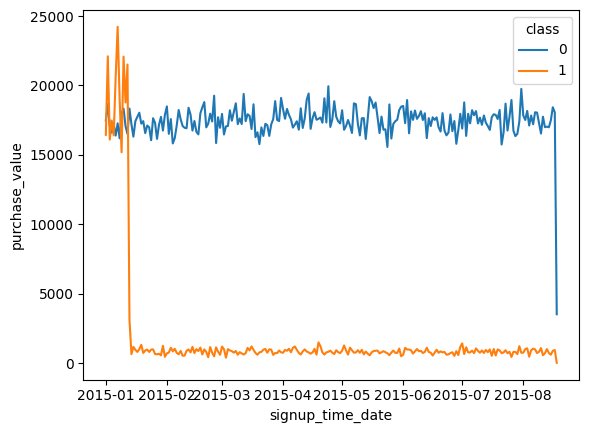

In [20]:
sns.lineplot(x="signup_time_date", y="purchase_value",
             hue = 'class',
             data=tmp_df)

In [21]:
tmp_df = pd.DataFrame(fraud_data.groupby(['purchase_time_date', 'class'])['purchase_value'].sum()).reset_index()
tmp_df

,purchase_time_date,class,purchase_value
0,2015-01-01,0,37
1,2015-01-01,1,15648
2,2015-01-02,0,209
3,2015-01-02,1,21163
4,2015-01-03,0,240
...,...,...,...
688,2015-12-13,0,397
689,2015-12-13,1,27
690,2015-12-14,0,171
691,2015-12-15,0,93


<Axes: xlabel='purchase_time_date', ylabel='purchase_value'>

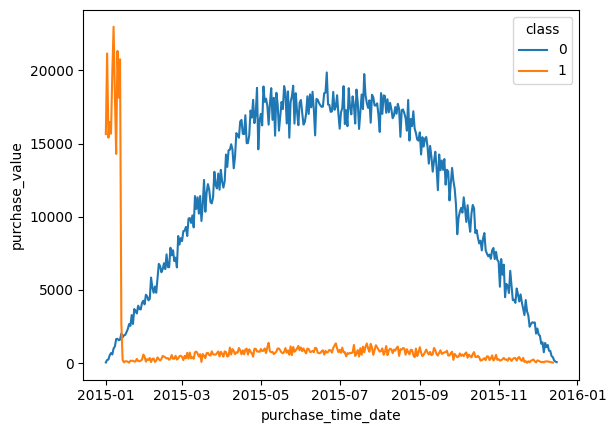

In [22]:
sns.lineplot(x="purchase_time_date", y="purchase_value",
             hue = 'class',
             data=tmp_df)

In [130]:
tmp_df = pd.DataFrame(fraud_data.groupby(['time_to_purchase', 'class'])['purchase_value'].mean()).reset_index()
tmp_df

,time_to_purchase,class,purchase_value
0,0,0,37.071910
1,0,1,36.901620
2,1,0,36.160855
3,1,1,40.500000
4,2,0,37.608343
...,...,...,...
237,118,1,34.549020
238,119,0,37.260917
239,119,1,35.833333
240,120,0,36.787140


<Axes: xlabel='time_to_purchase', ylabel='purchase_value'>

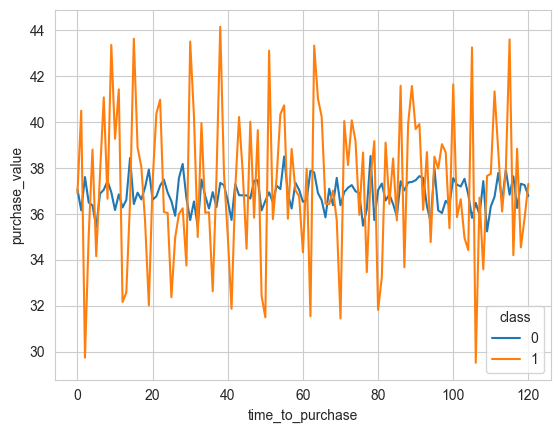

In [133]:
sns.lineplot(x="time_to_purchase", y="purchase_value",
             hue = 'class',
             data=tmp_df)

In [242]:
tmp_df_mean = pd.DataFrame(fraud_data.groupby('time_to_purchase')['purchase_value'].mean()).reset_index()
tmp_df_max  = pd.DataFrame(fraud_data.groupby('time_to_purchase')['purchase_value'].max()).reset_index()
tmp_df_min  = pd.DataFrame(fraud_data.groupby('time_to_purchase')['purchase_value'].min()).reset_index()
tmp_df_std  = pd.DataFrame(fraud_data.groupby('time_to_purchase')['purchase_value'].std()).reset_index().fillna(0)
tmp_df_purchase = pd.merge(tmp_df_max, tmp_df_min, on = 'time_to_purchase', how = 'left')
tmp_df_purchase = pd.merge(tmp_df_purchase, tmp_df_mean, on = 'time_to_purchase', how = 'left')
tmp_df_purchase = pd.merge(tmp_df_purchase, tmp_df_std, on = 'time_to_purchase', how = 'left')
# tmp_df_purchase['max_min_diff'] = tmp_df_purchase['purchase_value_x'] - tmp_df_purchase['purchase_value_y']
# tmp_df_purchase.columns = ['time_to_purchase', 'class', 'purchase_value_max', 'purchase_value_min', 'purchase_value_avg', 'purchase_value_std']
tmp_df_purchase

/var/folders/zs/v88g8hsn0_7361s2p51ms4100000gn/T/ipykernel_58794/2642245707.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'purchase_value_x'} in the result is deprecated and will raise a MergeError in a future version.
  tmp_df_purchase = pd.merge(tmp_df_purchase, tmp_df_std, on = 'time_to_purchase', how = 'left')


,time_to_purchase,purchase_value_x,purchase_value_y,purchase_value_x,purchase_value_y
0,0,100,9,36.913291,18.414455
1,1,101,9,36.320693,17.923950
2,2,106,9,37.235099,18.087782
3,3,111,9,36.440043,17.840491
4,4,111,9,36.497286,17.829758
...,...,...,...,...,...
116,116,110,9,37.433054,18.176641
117,117,98,9,36.408052,18.338383
118,118,115,9,37.178782,18.329162
119,119,114,9,37.189834,18.286410


In [250]:
tmp_df_mean = pd.DataFrame(fraud_data.groupby('device_id')['purchase_value'].mean()).reset_index()
tmp_df_max  = pd.DataFrame(fraud_data.groupby('device_id')['purchase_value'].max()).reset_index()
tmp_df_min  = pd.DataFrame(fraud_data.groupby('device_id')['purchase_value'].min()).reset_index()
tmp_df_std  = pd.DataFrame(fraud_data.groupby('device_id')['purchase_value'].std()).reset_index().fillna(0)

tmp_df_purchase = pd.merge(tmp_df_max, tmp_df_min, on = 'device_id', how = 'left')
tmp_df_purchase.columns = ['device_id', 'purchase_value_max', 'purchase_value_min']

tmp_df_purchase = pd.merge(tmp_df_purchase, tmp_df_mean, on = 'device_id', how = 'left')
tmp_df_purchase.columns = ['device_id', 'purchase_value_max', 'purchase_value_min', 'purchase_value_mean']

tmp_df_purchase = pd.merge(tmp_df_purchase, tmp_df_std, on = 'device_id', how = 'left')
tmp_df_purchase.columns = ['device_id', 'purchase_value_max', 'purchase_value_min', 'purchase_value_mean', 'purchase_value_std']

tmp_df_purchase['max_min_diff'] = tmp_df_purchase['purchase_value_max'] - tmp_df_purchase['purchase_value_min']

tmp_df_purchase.columns = ['device_id', 'purchase_value_max', 'purchase_value_min', 'purchase_value_avg', 'purchase_value_std', 'max_min_diff']
tmp_df_purchase

,device_id,purchase_value_max,purchase_value_min,purchase_value_avg,purchase_value_std,max_min_diff
0,AAAWIHVCQELTP,94,94,94.0,0.0,0
1,AAAXJHWCLISKY,46,46,46.0,0.0,0
2,AAAXXOZJRZRAO,57,57,57.0,0.0,0
3,AABFGRPBQHWFQ,10,10,10.0,0.0,0
4,AABJEESQPJHDQ,21,21,21.0,0.0,0
...,...,...,...,...,...,...
110594,ZZZGSIJRNCXBJ,18,18,18.0,0.0,0
110595,ZZZIKLJSVSQMF,55,55,55.0,0.0,0
110596,ZZZKJIZHJEDFN,59,59,59.0,0.0,0
110597,ZZZMVOGBAJVTM,49,49,49.0,0.0,0


#### purchase_value per device_id & class

In [229]:
tmp_df_purchase_value_stddev = pd.DataFrame(fraud_data.groupby(['device_id', 'class'])['purchase_value'].std()).reset_index()
# tmp_df_purchase_value_stddev = tmp_df_purchase_value_stddev.fillna(tmp_df_purchase_value_stddev.groupby('device_id')['purchase_value'].transform('mean'))
tmp_df_purchase_value_stddev.columns = ['device_id', 'class', 'purcahse_value_per_device_id_stddev']
tmp_df_purchase_value_stddev

,device_id,class,purcahse_value_per_device_id_stddev
0,AAAWIHVCQELTP,0,NaN
1,AAAXJHWCLISKY,0,NaN
2,AAAXXOZJRZRAO,0,NaN
3,AAAXXOZJRZRAO,1,0.0
4,AABFGRPBQHWFQ,0,NaN
...,...,...,...
112452,ZZZGSIJRNCXBJ,0,NaN
112453,ZZZIKLJSVSQMF,0,NaN
112454,ZZZKJIZHJEDFN,0,NaN
112455,ZZZMVOGBAJVTM,0,NaN


In [230]:
tmp = pd.DataFrame(fraud_data.groupby(['device_id', 'class'])['purchase_value'].std() / fraud_data.groupby(['device_id', 'class'])['purchase_value'].mean())#.fillna(0)

In [231]:
tmp_df_purchase_value_stddev = pd.merge(tmp_df_purchase_value_stddev, tmp, on=['device_id', 'class'], how='left')
tmp_df_purchase_value_stddev.columns = ['device_id', 'class', 'purcahse_value_per_device_id_stddev', 'purcahse_value_per_device_id_cv']
tmp_df_purchase_value_stddev = tmp_df_purchase_value_stddev.fillna(0)

In [232]:
tmp_df_purchase_value_stddev

,device_id,class,purcahse_value_per_device_id_stddev,purcahse_value_per_device_id_cv
0,AAAWIHVCQELTP,0,NaN,NaN
1,AAAXJHWCLISKY,0,NaN,NaN
2,AAAXXOZJRZRAO,0,NaN,NaN
3,AAAXXOZJRZRAO,1,0.0,0.0
4,AABFGRPBQHWFQ,0,NaN,NaN
...,...,...,...,...
112452,ZZZGSIJRNCXBJ,0,NaN,NaN
112453,ZZZIKLJSVSQMF,0,NaN,NaN
112454,ZZZKJIZHJEDFN,0,NaN,NaN
112455,ZZZMVOGBAJVTM,0,NaN,NaN


<Axes: xlabel='class', ylabel='purcahse_value_per_device_id_stddev'>

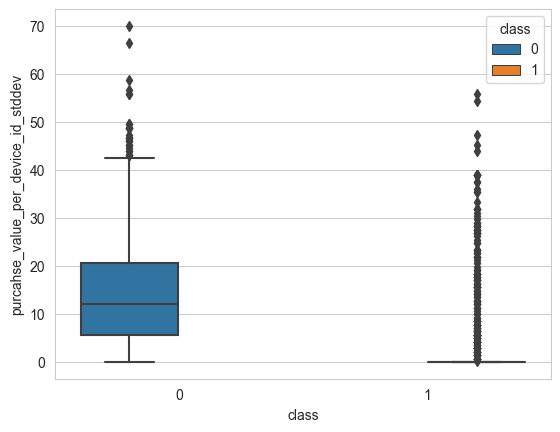

In [233]:
sns.boxplot(x="class", y="purcahse_value_per_device_id_stddev",
             hue = 'class',
             data=tmp_df_purchase_value_stddev)

In [253]:
fraud_data = pd.merge(fraud_data, tmp_df_purchase, on='device_id', how='left')
fraud_data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,signup_time_date,purchase_time_date,time_to_purchase,purchase_value_max,purchase_value_min,purchase_value_avg,purchase_value_std,max_min_diff
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,2015-07-15,2015-09-10,57,40,31,35.5,6.363961,9
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,2015-01-24,2015-04-13,79,31,31,31.0,0.000000,0
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,2015-03-11,2015-04-05,25,16,16,16.0,0.000000,0
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,2015-01-07,2015-01-09,2,29,29,29.0,0.000000,0
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,2015-02-08,2015-04-09,60,26,26,26.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,116698,2/26/2015 11:51,4/16/2015 22:57,46,UJYRDGZXTFFJG,Ads,Chrome,M,18,2.509395e+09,0,2015-02-26,2015-04-16,49,46,46,46.0,0.000000,0
119996,122699,8/1/2015 18:40,8/25/2015 7:56,26,EMMTCPTUYQYPX,Ads,IE,F,36,2.946612e+09,0,2015-08-01,2015-08-25,24,26,26,26.0,0.000000,0
119997,115120,7/25/2015 12:50,9/3/2015 4:10,41,YSZGGEARGETEU,SEO,Chrome,M,31,5.570629e+08,0,2015-07-25,2015-09-03,40,41,41,41.0,0.000000,0
119998,87098,4/2/2015 21:11,6/22/2015 16:51,50,BJDWRJULJZNOV,SEO,Chrome,F,43,2.687887e+09,0,2015-04-02,2015-06-22,81,50,50,50.0,0.000000,0


## source

In [25]:
tmp_df = pd.DataFrame(fraud_data.groupby(['time_to_purchase', 'source', 'class'])['user_id'].count()).reset_index()
tmp_df

,time_to_purchase,source,class,user_id
0,0,Ads,0,171
1,0,Ads,1,2382
2,0,Direct,0,86
3,0,Direct,1,1312
4,0,SEO,0,188
...,...,...,...,...
721,120,Ads,1,7
722,120,Direct,0,97
723,120,Direct,1,6
724,120,SEO,0,178


<Axes: xlabel='time_to_purchase', ylabel='user_id'>

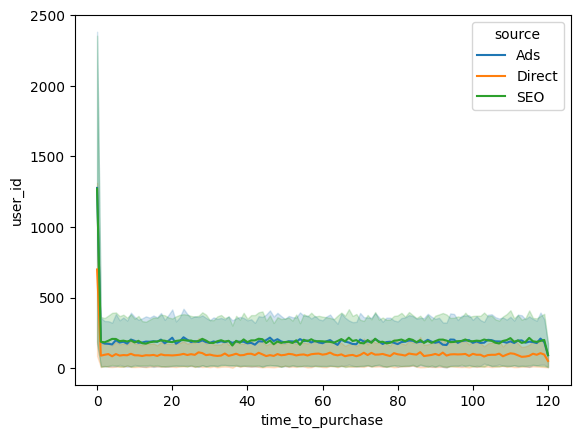

In [26]:
sns.lineplot(x="time_to_purchase", y="user_id",
             hue = 'source',
             data=tmp_df)

## sex

In [27]:
tmp_df = pd.DataFrame(fraud_data.groupby(['sex', 'class'])['user_id'].count()).reset_index()
tmp_df

,sex,class,user_id
0,F,0,45302
1,F,1,4572
2,M,0,63433
3,M,1,6693


<Axes: xlabel='sex', ylabel='user_id'>

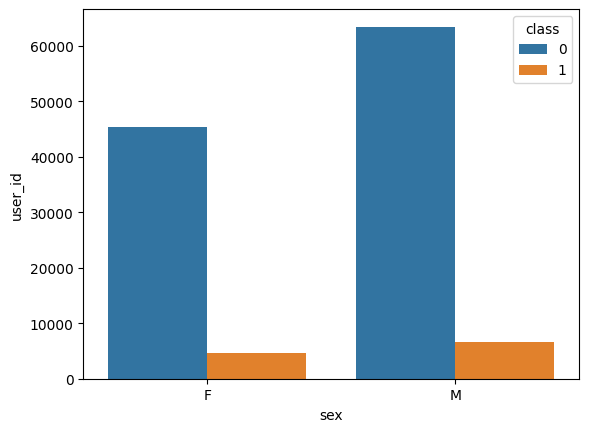

In [28]:
sns.barplot(tmp_df, x = 'sex', y = 'user_id', hue='class')

## browser

In [29]:
tmp_df = pd.DataFrame(fraud_data.groupby(['browser', 'class'])['user_id'].count()).reset_index()
tmp_df

,browser,class,user_id
0,Chrome,0,43814
1,Chrome,1,4838
2,FireFox,0,17769
3,FireFox,1,1846
4,IE,0,26629
5,IE,1,2509
6,Opera,0,2703
7,Opera,1,272
8,Safari,0,17820
9,Safari,1,1800


<Axes: xlabel='browser', ylabel='user_id'>

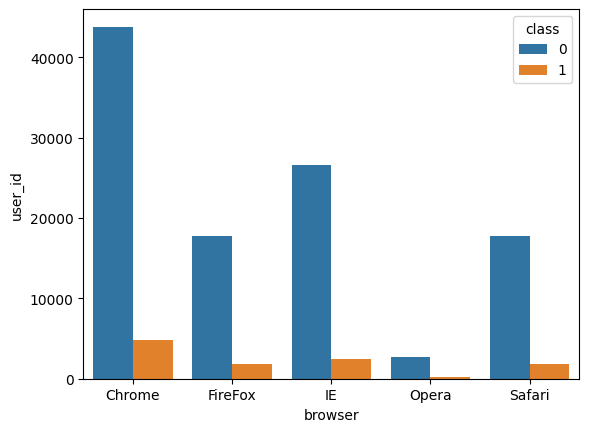

In [30]:
sns.barplot(tmp_df, x = 'browser', y = 'user_id', hue='class')

## device_id

> some device_id have lots of user_ids and that is not normal case and could be suspicious

In [31]:
## some devices have multiple user_id
tmp_df = pd.DataFrame(fraud_data.groupby(['device_id'])['user_id'].count()).reset_index()
tmp_df = tmp_df.sort_values(by = 'user_id', ascending=False)
tmp_df.head()

,device_id,user_id
37046,ITUMJCKWEYNDD,19
43705,KIPFSCNUGOLDP,17
19764,EQYVNEGOFLAWK,17
109743,ZUSVMDEZRBDTX,17
85930,UFBULQADXSSOG,16


- check if multiple users are fraud
    - these two cells right below show that if device_id has more than 3 user_id, that user_ids under device_id could be fraud

In [118]:
## check if multiple users are fraud
## this cell and right below cell show that if device_id has more than 3 user_id, that user_ids under device_id could be fraud
tmp_df = pd.DataFrame(fraud_data.groupby(['device_id', 'class'])['user_id'].count()).reset_index()
tmp_df = tmp_df.sort_values(by = 'user_id', ascending=False)
tmp_df.loc[tmp_df['class']==1].head(15)

,device_id,class,user_id
37667,ITUMJCKWEYNDD,1,18
20102,EQYVNEGOFLAWK,1,17
44474,KIPFSCNUGOLDP,1,16
111574,ZUSVMDEZRBDTX,1,16
9172,CDFXVYHOIHPYP,1,16
78498,SDJQRPKXQFBED,1,15
81225,SUEKLSZWLASFR,1,15
35421,IGKYVZDBEGALB,1,15
38306,IXNWEKWJGNLNH,1,15
31260,HGVNRPOHIBZLJ,1,14


In [119]:
tmp_df.loc[tmp_df['class']==0].head(15)

,device_id,class,user_id
49371,LLVQVKNEEXFMS,0,3
25058,FUJYPBUMWDXTO,0,3
78019,SANQZCPGRCERN,0,3
82429,TBEXEPAUWGUWW,0,3
10848,CMYNZQLGTENFH,0,3
81586,SWHJOBVGERQIP,0,3
20388,ESTKJLLKCHBMW,0,3
54842,MSXHVARAESYVD,0,3
85639,TUTIBAJWVRPPI,0,3
23811,FNEYHXIWZGQGA,0,3


- check the scale

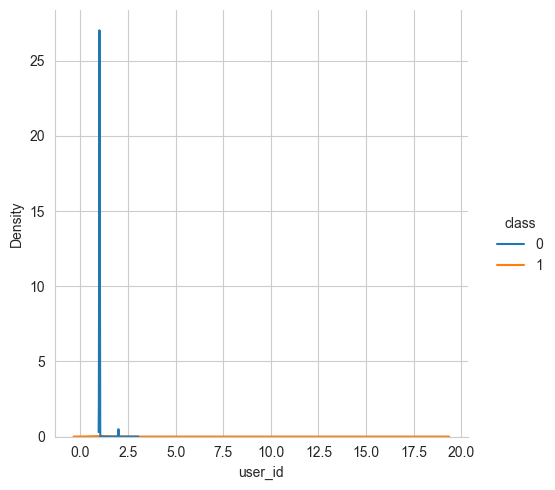

In [120]:
sns.displot(data=tmp_df, x="user_id", hue="class", kind="kde")

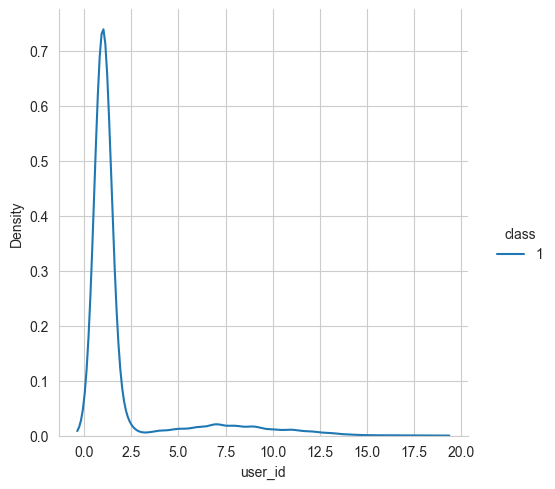

In [121]:
sns.displot(data=tmp_df.loc[tmp_df['class'] == 1], x="user_id", hue="class", kind="kde")

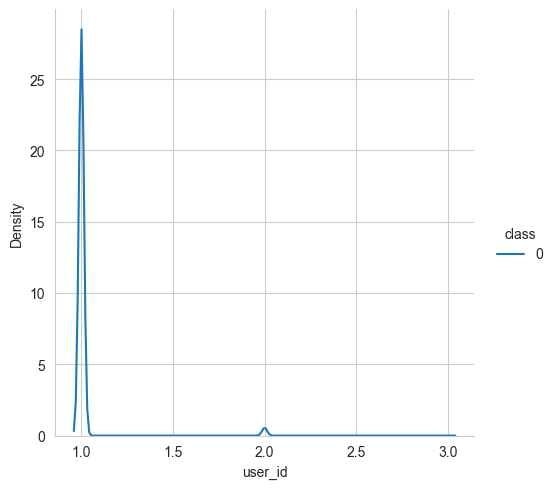

In [122]:
sns.displot(data=tmp_df.loc[tmp_df['class'] == 0], x="user_id", hue="class", kind="kde")

#### make additional column about device_id

In [109]:
tmp_df = pd.DataFrame(fraud_data.groupby(['device_id'])['user_id'].count()).reset_index()
tmp_df.columns = ['device_id', 'user_id_count']

In [110]:
fraud_data = pd.merge(fraud_data, tmp_df, on='device_id', how='left')
fraud_data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,signup_time_date,purchase_time_date,time_to_purchase,user_id_count
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,2015-07-15,2015-09-10,57,2
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,2015-01-24,2015-04-13,79,1
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,2015-03-11,2015-04-05,25,1
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,2015-01-07,2015-01-09,2,1
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,2015-02-08,2015-04-09,60,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,116698,2/26/2015 11:51,4/16/2015 22:57,46,UJYRDGZXTFFJG,Ads,Chrome,M,18,2.509395e+09,0,2015-02-26,2015-04-16,49,1
119996,122699,8/1/2015 18:40,8/25/2015 7:56,26,EMMTCPTUYQYPX,Ads,IE,F,36,2.946612e+09,0,2015-08-01,2015-08-25,24,1
119997,115120,7/25/2015 12:50,9/3/2015 4:10,41,YSZGGEARGETEU,SEO,Chrome,M,31,5.570629e+08,0,2015-07-25,2015-09-03,40,1
119998,87098,4/2/2015 21:11,6/22/2015 16:51,50,BJDWRJULJZNOV,SEO,Chrome,F,43,2.687887e+09,0,2015-04-02,2015-06-22,81,1


## age

In [31]:
tmp_df = pd.DataFrame(fraud_data.groupby(['age', 'class'])['user_id'].count()).reset_index()
tmp_df

,age,class,user_id
0,18,0,1987
1,18,1,215
2,19,0,2111
3,19,1,199
4,20,0,2427
...,...,...,...
100,70,0,1
101,71,0,1
102,72,0,2
103,73,0,1


<Axes: xlabel='age', ylabel='user_id'>

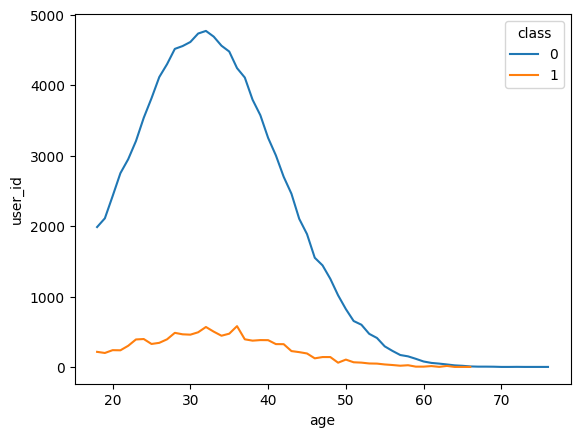

In [32]:
sns.lineplot(x="age", y="user_id",
             hue = 'class',
             data=tmp_df)

# Make country column using ip-country info table

In [254]:
fraud_data['country'] = fraud_data['ip_address'].map(lambda x :str(ip_info.loc[(ip_info['lower_bound_ip_address'] <= x) & (x <= ip_info['upper_bound_ip_address']) ,'country' ].values)[2:-2])

In [255]:
fraud_data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,signup_time_date,purchase_time_date,time_to_purchase,purchase_value_max,purchase_value_min,purchase_value_avg,purchase_value_std,max_min_diff,country
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,2015-07-15,2015-09-10,57,40,31,35.5,6.363961,9,United States
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,2015-01-24,2015-04-13,79,31,31,31.0,0.000000,0,United Kingdom
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,2015-03-11,2015-04-05,25,16,16,16.0,0.000000,0,United States
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,2015-01-07,2015-01-09,2,29,29,29.0,0.000000,0,Korea Republic of
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,2015-02-08,2015-04-09,60,26,26,26.0,0.000000,0,Brazil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,116698,2/26/2015 11:51,4/16/2015 22:57,46,UJYRDGZXTFFJG,Ads,Chrome,M,18,2.509395e+09,0,2015-02-26,2015-04-16,49,46,46,46.0,0.000000,0,Netherlands
119996,122699,8/1/2015 18:40,8/25/2015 7:56,26,EMMTCPTUYQYPX,Ads,IE,F,36,2.946612e+09,0,2015-08-01,2015-08-25,24,26,26,26.0,0.000000,0,China
119997,115120,7/25/2015 12:50,9/3/2015 4:10,41,YSZGGEARGETEU,SEO,Chrome,M,31,5.570629e+08,0,2015-07-25,2015-09-03,40,41,41,41.0,0.000000,0,United States
119998,87098,4/2/2015 21:11,6/22/2015 16:51,50,BJDWRJULJZNOV,SEO,Chrome,F,43,2.687887e+09,0,2015-04-02,2015-06-22,81,50,50,50.0,0.000000,0,Switzerland


#### class per country - almost same proportion

In [76]:
tmp_df = pd.DataFrame(fraud_data.loc[fraud_data['class']==1,].groupby(['country', 'class'])['user_id'].count()).reset_index()
tmp_df.sort_values(by='user_id', ascending=False, inplace = True)

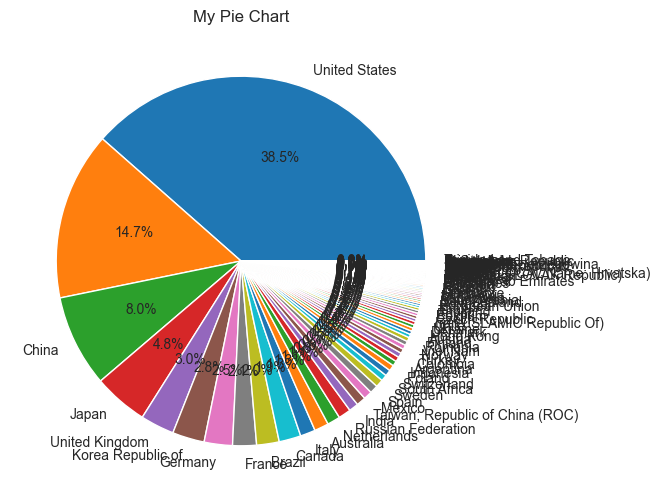

In [75]:
## class = 0
tmp_df_ = tmp_df.iloc[0:100,:]
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(tmp_df_['user_id'], labels=tmp_df_['country'], autopct='%1.1f%%')
plt.title('My Pie Chart')
plt.show()

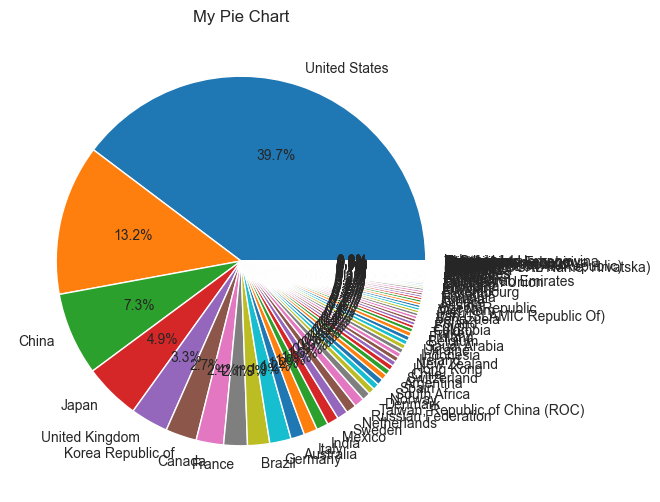

In [77]:
tmp_df_ = tmp_df.iloc[0:100,:]
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(tmp_df_['user_id'], labels=tmp_df_['country'], autopct='%1.1f%%')
plt.title('My Pie Chart')
plt.show()

### user_id / device_id / ip_address

- user_id   : one ip_address at most, also one device_id at most
- device_id : can have more than one ip_address / user_id

- Therefore, ip_address count and user_id count based on device_id have more information than based on user_id
    - chekce how many ip and user_id are connected belong to the device_id of user_id

In [95]:
tmp_df_ipaddress = pd.DataFrame(fraud_data.groupby(['device_id'])['ip_address'].count()).reset_index()
tmp_df_ipaddress.sort_values(by='ip_address', ascending=False, inplace = True)
tmp_df_ipaddress.columns = ['device_id', 'device_id_ip_count']
tmp_df_ipaddress

,device_id,device_id_ip_count
37046,ITUMJCKWEYNDD,19
43705,KIPFSCNUGOLDP,17
19764,EQYVNEGOFLAWK,17
109743,ZUSVMDEZRBDTX,17
85930,UFBULQADXSSOG,16
...,...,...
37554,IWXNQWGGGXVEA,1
37553,IWXHUPWZCKOTJ,1
37552,IWXEZSEZPTXGF,1
37551,IWWSBBPEUHDUP,1


In [256]:
fraud_data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'signup_time_date', 'purchase_time_date', 'time_to_purchase',
       'purchase_value_max', 'purchase_value_min', 'purchase_value_avg',
       'purchase_value_std', 'max_min_diff', 'country'],
      dtype='object')

## Possible important features
- user_id count per device_id
- time diff between first purchase and signup

## which could be misclassified?
- (time diff between first purchase and signup > 4) & (user_id count per divice_id < 4)
    - purchase_value can be a strong feature 
    - purchase_value stddev per device_id

In [257]:
fraud_data.to_csv('df_final.csv')